# Introduction to `pandora-sat`

`pandora-sat` is a simulator for Pandora data that is currently under development. 

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pandorasat as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
plt.style.use('seaborn-white')

You can initialize the observatory using

In [3]:
p = ps.PandoraSat()

You can see different detectors of the observatory using

In [4]:
nirda = p.NIRDA
visda = p.VISDA

## Basic Detector Properties

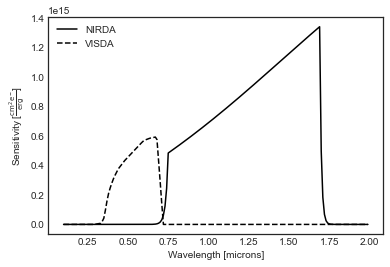

In [5]:
w = np.arange(0.1, 2, 0.01) * u.micron
fig, ax = plt.subplots()
ax.plot(w, nirda.sensitivity(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.sensitivity(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{nirda.sensitivity(w).unit.to_string('latex')}]")
plt.legend()

You can estimate the flux/magnitude of a source

In [6]:
nirda.flux_from_mag(10)

<Quantity 3.63869248e-14 erg / (Angstrom cm2 s)>

In [7]:
visda.flux_from_mag(10)

<Quantity 3.76036826e-13 erg / (Angstrom cm2 s)>

In [8]:
nirda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 13.90236338>

In [9]:
visda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 16.43807595>

Detector have properties

In [10]:
visda.dark

<Quantity 2. electron / s>

In [11]:
visda.read_noise

<Quantity 2.1 electron>

## CH: ADD NIRDA NOISE PROPERTIES

You can take a look at the PSFs and PRFs for each detector with the `diagnose` function

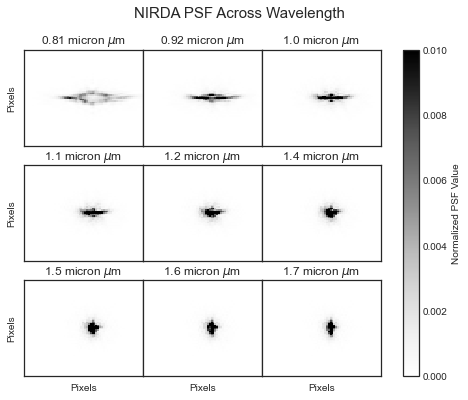

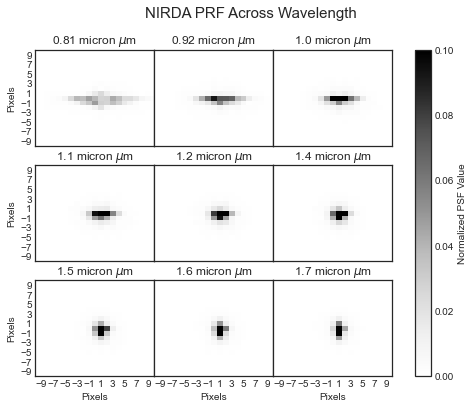

In [12]:
nirda.diagnose(n=3, image_type='psf');
nirda.diagnose(n=3, image_type='prf');

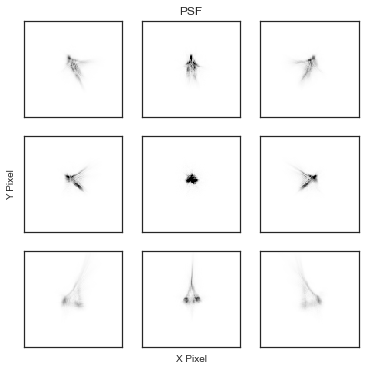

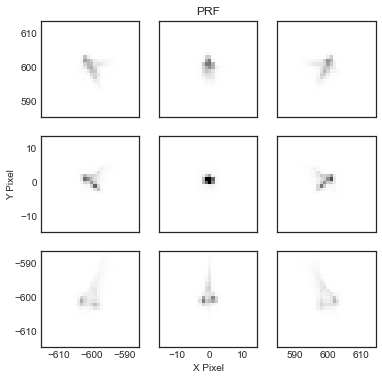

In [13]:
visda.diagnose(n=3, image_type='psf');
visda.diagnose(n=3, image_type='prf');

## Targets

To make simulations you'll need targets with information about the SED. You can get those either using:


In [14]:
target = ps.Target('GJ 436').from_vizier()

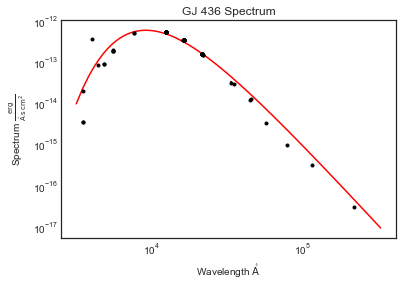

In [15]:
target.plot_spectrum();

or

In [16]:
target = ps.Target('GJ 436').from_phoenix()

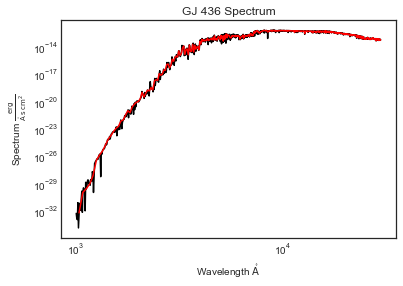

In [17]:
target.plot_spectrum();

`targets` have some helpful attributes including

In [18]:
target.ra

175.54622244662

In [19]:
target.dec

26.706571692

In [20]:
target.teff

3456.0

In [21]:
target.jmag

6.900000095367432

In [22]:
target.tmag

8.402999877929688

## Making Visible Image Simulations

To make image simulations you need to point the observatory at a target and get the sky catalog

In [23]:
target = ps.Target('HAT-P-19').from_phoenix()

In [24]:
target.planets['b']['pl_orbper']

<Quantity 4.008778 d>

In [25]:
# the observatory has the `get_sky_catalog` method for now
source_catalog = p.get_sky_catalog(target.ra, target.dec)

In [26]:
source_catalog.head()

,ra,dec,mag,vis_x,vis_y,nir_x,nir_y,vis_counts,vis_flux
0,9.516723,34.711542,13.0889,1024.000000,1024.000000,1064.000000,2048.000000,34443.387102,2.186102e-14
1,9.539047,34.693664,13.0567,939.285261,941.493870,1008.472692,1993.920352,35480.183120,2.251907e-14
2,9.507223,34.750926,14.1134,1060.025604,1205.774581,1087.613421,2167.146364,13406.204894,8.508840e-15
3,9.498315,34.657354,15.2956,1093.886844,773.906170,1109.808184,1884.072952,4512.589750,2.864115e-15
4,9.506904,34.770621,14.2464,1061.226987,1296.671866,1088.400883,2226.726097,11860.577964,7.527840e-15


In [27]:
len(source_catalog)

46

You can then get an image of the sky on the visible camera

In [28]:
# The observatory get's the sky image because eventually it will return images from both detectors.
nreads = 4
img = p.get_sky_image(source_catalog, nreads=nreads, include_noise=True)

In [29]:
%load_ext line_profiler

In [30]:
%lprun -f p.get_sky_image p.get_sky_image(source_catalog, nreads=nreads, include_noise=True)

Timer unit: 1e-06 s

Total time: 0.658362 s
File: /Users/chedges/repos/pandora-sat/src/pandorasat/pandorasat.py
Function: get_sky_image at line 93

Line #      Hits         Time  Per Hit   % Time  Line Contents
    93                                               def get_sky_image(self, source_catalog, wavelength=0.54*u.micron, temperature=10*u.deg_C, nreads=1, include_noise=True):
    94         2       4508.0   2254.0      0.7          science_image = np.zeros(
    95         1         22.0     22.0      0.0              (self.VISDA.naxis1.value.astype(int), self.VISDA.naxis2.value.astype(int))
    96                                                   )
    97        47       3893.0     82.8      0.6          for idx, s in source_catalog.iterrows():
    98        46       1400.0     30.4      0.2              x, y = s.vis_x - self.VISDA.naxis1.value//2, s.vis_y - self.VISDA.naxis2.value//2
    99        46         56.0      1.2      0.0              if ((x < -650) | (x > 650) | (y < -

In [31]:
img.shape

(2048, 2048)

Below is a plot of the VISDA sky image. In future, this will also great a NIRDA image.

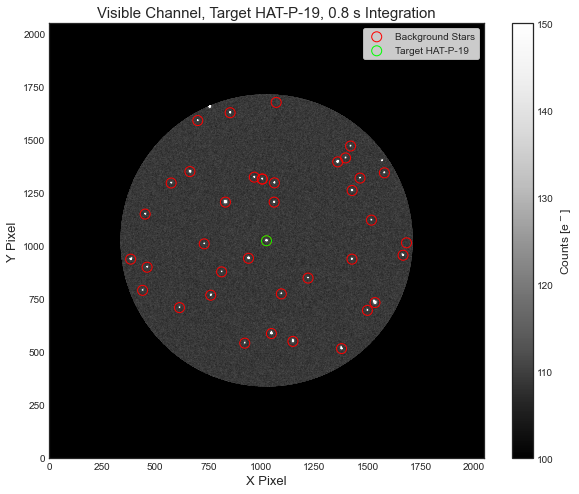

In [32]:
plt.figure(figsize=(10, 8))
plt.imshow(img.value, origin='lower', vmin=100, vmax=150, cmap='Greys_r')
cbar = plt.colorbar()
cbar.set_label('Counts [e$^-$]', fontsize=12)
plt.title(f'Visible Channel, {target}, {visda.integration_time*nreads} Integration', fontsize=15)
plt.xlabel("X Pixel", fontsize=13)
plt.ylabel("Y Pixel", fontsize=13)
k = np.hypot(source_catalog.vis_x - visda.naxis1.value/2, source_catalog.vis_y - visda.naxis2.value/2) < 1320/2
plt.scatter(source_catalog.vis_x[k], source_catalog.vis_y[k], edgecolor='r', facecolor='None', s=100, label='Background Stars')
plt.scatter(source_catalog.vis_x[0], source_catalog.vis_y[0], edgecolor='lime', facecolor='None', s=100, label=f'{target}')
plt.legend(frameon=True)

# Making NIRDA Traces

You can get an example trace of a target on the NIRDA detector using a

In [33]:
wavelength = np.linspace(0.1, 2, 6000) * u.micron
spectrum = target.model_spectrum(wavelength)
trace = nirda.get_trace(wavelength, spectrum, pixel_resolution=2)

[Text(0.5, 0, 'Pixels'), Text(0, 0.5, 'Pixels')]

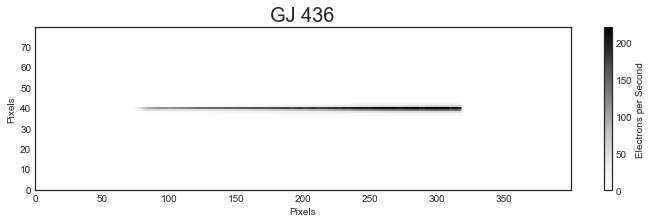

In [34]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.pcolormesh(np.arange(trace.shape[1]), np.arange(trace.shape[0]), trace.value)
cbar = plt.colorbar()
cbar.set_label("Electrons per Second")
plt.title('GJ 436', fontsize=20)
ax.set(xlabel='Pixels', ylabel='Pixels')

# Making realistic data simulations

In [35]:
target = ps.Target('HAT-P-19').from_phoenix()

Find the time baseline for observations

In [36]:
# Set a number of frames
nframes = 40
exptime = nframes * nirda.frame_time
time = np.arange(target.planets['b']['pl_tranmid'].value - 0.3, target.planets['b']['pl_tranmid'].value + 0.3, exptime.to(u.day).value)

# Drop some parts of the orbit because of Earth occultation
c = (90*u.minute).to(u.day).value
time = time[((time % c) > c * 0.3)]
cyc = time - (time % c)
time = time[(cyc != np.unique(cyc)[0]) & (cyc != np.unique(cyc)[-1])]

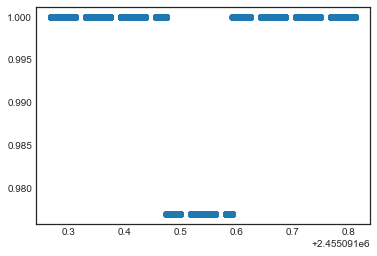

In [37]:
plt.scatter(time, target.box_transit(time))

In [38]:
integration = nirda.get_integration(wavelength, spectrum, nframes=nframes)

100%|███████████████████████████████████████████| 40/40 [00:17<00:00,  2.26it/s]


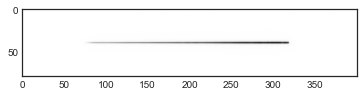

In [39]:
plt.imshow(integration)

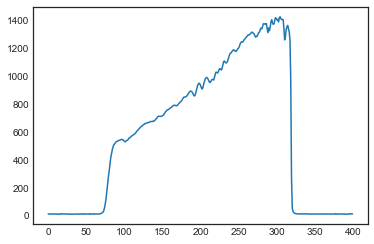

In [40]:
plt.plot(integration[38:42].mean(axis=0))

In [41]:
%load_ext line_profiler

In [948]:
%lprun -f nirda.psf.prf nirda.get_trace(wavelength, spectrum.value**0 * spectrum.unit, target_center=[40, 250])

Timer unit: 1e-06 s

Total time: 0.464871 s
File: /Users/chedges/repos/pandora-sat/src/pandorasat/psf.py
Function: prf at line 151

Line #      Hits         Time  Per Hit   % Time  Line Contents
   151                                               def prf(self, point, location=None, freeze_dimensions=None):
   152                                                   """
   153                                                   Bins the PSF down to the pixel scale.
   154                                           
   155                                                   Parameters
   156                                                   ----------
   157                                                   point: tuple
   158                                                       The point to interpolate at, in `self.dimension_names`
   159                                                   location: tuple
   160                                                       The location in pixels on the

In [1071]:
nx, ny = 8, 8
xcs, ycs = np.linspace(-0.5, 0.5, nx + 1)[:-1], np.linspace(-0.5, 0.5, ny + 1)[:-1]
psfs = np.zeros((nx, ny, 80, 50))
for idx, xc in tqdm(enumerate(xcs), position=0, leave=True, total=nx):
    for jdx, yc in enumerate(ycs):
        x1, y1, f = nirda.psf.prf(nirda.psf.midpoint, location=[40+yc, 25+xc])
        X, Y = np.asarray(np.meshgrid(x1, y1)).astype(int)
        psfs[idx, jdx, X, Y] = f.T

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 161.05it/s]


In [1115]:
x1 = (np.arange(0, 300)[:, None] + xcs).ravel()
idxs = (np.arange(nx)[None, :] + np.ones(300)[:, None]).astype(int).ravel()

In [1125]:
ar = np.zeros((80, 400))
k = np.where(ycs == 0)[0][0]
for idx in range(300):
    ar[:, idx:50+idx] += psfs[:, k].sum(axis=0)

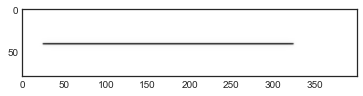

In [1126]:
plt.imshow(ar)

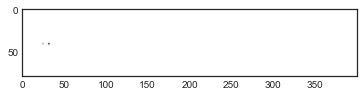

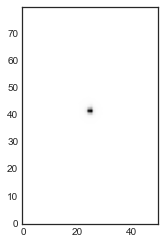

In [1122]:
plt.imshow(psfs[:, k].sum(axis=(0)), origin='lower')

/Users/chedges/Library/Caches/pypoetry/virtualenvs/pandorasat-O34My1_v-py3.9/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


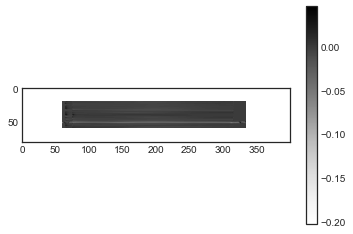

In [915]:
plt.imshow((trace1 - trace2)/trace1)
plt.colorbar()